#### Imports


In [941]:
from __future__ import division
from scipy import misc
import numpy as np
import matplotlib.pyplot as plt
import pyproximal

#### Definitions

We define the discrete gradient operator $D$ and its adjoint $D^*$.

In [942]:
D = lambda x : np.c_['2,3',np.r_[np.diff(x,1,0), np.zeros([1,x.shape[1]])],np.c_[np.diff(x,1,1), np.zeros([x.shape[0],1])]]

In [943]:
Dadj = lambda v : np.r_['0,2',-v[0,:,0],-np.diff(v[:-1,:,0],1,0),v[-2,:,0]] + np.c_['1,2',-v[:,0,1],-np.diff(v[:,:-1,1],1,1),v[:,-2,1]]

We regularize the strongly convex primal problem by adding the corresponding LASSO term :
$$\min_{x \in \R^{N_1\times N_2}} E_p(x)= f(x)+ g(Dx) + \alpha \lVert x \rVert_{1} =\frac{1}{2}\|x-y\|^2+\lambda\|Dx\|_{1,2} + \alpha \lVert Dx \rVert_{1}$$


Which is equivalent to

$$\min_{x \in \R^{N_1\times N_2}} E_p(x)= \frac{1}{2}\|x-y\|^2+ h(Dx)$$

Where :

$$ h(x) = f(x) + g(x), \text{and} $$
$$ f(x) = \lambda\|x\|_{1,2}  $$
$$ g(x) =  \alpha \lVert x \rVert_{1} $$ 

Therefore, we have to adapt the proximal operator for $h$, knowing that :

$$ x = \text{prox}_{\gamma h^*}(x) + \gamma \text{prox}_{h/\gamma}(x/\gamma) $$

Moreover, we will first assume that

$$ \text{prox}_{\gamma h}(x) =  \text{prox}_{\gamma g}(x) \circ \text{prox}_{\gamma f}(x)  $$

Thus yielding


$$\begin{aligned}

\big(\text{prox}_{\gamma h^*}(u)\big) = u - \gamma \text{prox}_{h/\gamma}(u/\gamma) \\
= u - \gamma \text{prox}_{g / \gamma}(\text{prox}_{f / \gamma}(u/\gamma) ) 
\end{aligned}$$

With

$$\text{prox}_{g/\gamma}(u) = \text{defined numerically, or by } \ \text{sign}(u) \cdot max\{0;|u| - \alpha/\gamma\} $$

Regarding $\text{prox}_{f/\gamma}(u/\gamma)$, we know that for $f(x) =  \lambda \ \lVert x \rVert_{1,2} $, we have 

$$\big(\text{prox}_{\gamma f^*}(u)\big)_{n_1,n_2}=\frac{1}{\max(\|u_{n_1,n_2}\|_2/\lambda,1)}u_{n_1,n_2}\in\mathbb{R}^2,\quad\forall (n_1,n_2).$$ 

Using the Moreau identity once again, and in the context of our newly defined problem, we can write 

$$

 \gamma \text{prox}_{f/\gamma}(u/\gamma) = u - \big(\text{prox}_{\gamma f^*}(u)\big) 
$$


$$
\Rightarrow \text{prox}_{f/\gamma}(u/\gamma) = \frac{u - \big(\text{prox}_{\gamma f^*}(u)\big)}{\gamma} 
$$

Knowing that $\big(\text{prox}_{\gamma f^*}(u)\big)$ is implemented as :


In [944]:
def prox_f_conj (u, Lambda) :
    return u/np.tile(np.maximum(np.sqrt(np.sum(u**2,2,keepdims=True))/(Lambda),1),(1,1,2)) # soft-thresholding

We can implement this proximal operator as :

In [945]:
def proximal_TV_operator(u,gamma,Lambda) : 
    return( (u - prox_f_conj(u,Lambda)) / gamma)

#def proximal_TV_operator(x, gamma, Lambda):
#    """  
#    Applies the proximal operator of the TV term.
#    
#    Parameters
#    ----------
#    x : Multidim. array to which we apply the proximal operator. (np.ndarray)
#    gamma : The usual gamma term (float)
#    Lambda : Multiplicative coefficient of the TV term (float)
#
#    Returns 
#    ---------
#    prox_result : The resulting ndarray from the application of the "TV" proximal operator.
#
#    """
#    #Defining the TV operator (that's how pyproximal works apparently)
#    TV = pyproximal.TV(dims=x.shape, sigma=Lambda)
#    try:
#        #Apply the TV proximal operator to x/gamma, and reshape the result to what we need
#        prox_result = TV.prox((x / gamma),2).reshape((512,512,2))
#        #print(f"TV.prox result shape: {result.shape}")
#        return prox_result
#    except Exception as e:
#        print(f"Error in TV.prox: {e}")
#        raise

For the proximal operator of $g$, we can implement it as :

In [946]:
def proximal_operator_lasso(u, alpha,gamma):
    """  
    Applies the proximal operator of the L1 norm.
    
    Parameters
    ----------
    u : Multidim. array to which we apply the proximal operator. (np.ndarray)
    alpha : Constant that multiplies the L1 term, controlling regularization strength. (float)

    Returns 
    ---------
    The resulting ndarray from the application of the L1 norm proximal operator.

    """
    #return np.sign(u) * np.maximum(abs(u) - alpha,0)
    L1 = pyproximal.L1(sigma=alpha)
    try:
        #Apply the TV proximal operator to u, scaled by 1/gamma, then reshape the result to what we need
        prox_result = L1.prox(u,1/gamma).reshape(u.shape)
        #print(f"TV.prox result shape: {result.shape}")
        return prox_result
    except Exception as e:
        print(f"Error in TV.prox: {e}")
        raise

We can then add both into the proximal operator of $h$ :

In [947]:
def complete_proximal_operator(u, x, gamma, Lambda, alpha):
    """  
    Computes the final composition of proximal operators.
    
    Parameters
    ----------
    u : The u value of the current iteration (np.ndarray)
    x : The x value of the current iteration (np.ndarray)
    alpha : Constant that multiplies the L1 term, controlling regularization strength. (float)
    gamma : The usual gamma term (float)
    Lambda : Multiplicative coefficient of the TV term (float)

    Returns 
    ---------
    u^{k+1}, as described in Chambolle's algorithm.

    """
    #Computing the term at which we evaluate prox_h()
    redef_u = u + gamma * D(x)

    try:
        #Application of the proximal 'TV' operator...
        prox_tv = proximal_TV_operator(redef_u, gamma, Lambda)
        #... And successive application of the proximal 'lasso' operator
        prox_lasso = proximal_operator_lasso(prox_tv, alpha, gamma)
        proximal_composition = gamma * prox_lasso

        return redef_u - proximal_composition
    
    except Exception as e:
        print(f"Error in complete_proximal_operator: {e}")
        raise

## The original Chambolle algorithm

In the original implementation of the Chambolle algorithm the unisotropic term doesn't appear and the implementation is therefore much simpler :

In [949]:
def original_chambolle_algorithm(noised_image,Lambda,gamma,nbiter) :
    """
    Perform denoising on a noised image using the Chambolle's algorithm.

    Parameters
    ----------
    noised_image : Input image, corrupted by noise (2-D np.ndarray)
    Lambda : Multiplicative coefficient of the TV term (float)
    gamma : Proximal operators coefficient (float)
    alpha : Constant that multiplies the L1 term, controlling regularization strength. (float)
    nbiter : Number of iterations to run the algorithm (int)

    Returns
    -------
    xdenoised : The denoised image obtained after `nbiter` iterations. (2-D np.ndarray)
    Ep_array : Array containing the primal energy values at each iteration. (np.ndarray)
    Ed_array : Array containing the dual energy values at each iteration. (np.ndarray)

"""
    #Initializing u & x
    (N1,N2) = noised_image.shape
    u = np.zeros([N1,N2,2])
    x = np.zeros([N1,N2,2])

    #Initializing energy arrays
    Ep_array = np.zeros(nbiter) # array for the primal energy E_p
    Ed_array = np.zeros(nbiter) # array for the dual energy E_d

    #Squared norm of the noised image
    sqnormy = np.linalg.norm(noised_image)**2/2

    #Iterations of the Chambolle Algorithm
    for iter in range(nbiter):  

        #Computing x and u, appending resulting energies in their respective arrays
        x = -Dadj(u) + noised_image
        u = prox_f_conj(u+gamma*D(x),Lambda)
        Ep_array[iter] = np.linalg.norm(x-noised_image)**2/2 + Lambda*np.sum(np.sqrt(np.sum(D(x)**2,2))) 
        Ed_array[iter] = np.linalg.norm(noised_image-Dadj(u))**2/2 - sqnormy
    
    #Last x obtained is the denoised version of
    #  noised_image, we return it
    xdenoised = x
    return xdenoised,Ep_array,Ed_array


## Implementation of revised algorithm

We then implement this newly defined proximal operator into Chambolle's algorithm. As previously explained, the implementation stays the same, besides the computation of $u^{(k+1)}$, which is now defined as a composition of operators.

In [950]:
def chambolle_algorithm(noised_image,Lambda,gamma,alpha,nbiter) :
    """
    Perform denoising on a noised image using the Chambolle's algorithm.

    Parameters
    ----------
    noised_image : Input image, corrupted by noise (2-D np.ndarray)
    Lambda : Multiplicative coefficient of the TV term (float)
    gamma : Proximal operators coefficient (float)
    alpha : Constant that multiplies the L1 term, controlling regularization strength. (float)
    nbiter : Number of iterations to run the algorithm (int)

    Returns
    -------
    xdenoised : The denoised image obtained after `nbiter` iterations. (2-D np.ndarray)
    Ep_array : Array containing the primal energy values at each iteration. (np.ndarray)
    Ed_array : Array containing the dual energy values at each iteration. (np.ndarray)

"""
    #Initializing u & x
    (N1,N2) = noised_image.shape
    u = np.zeros([N1,N2,2])
    x = np.zeros([N1,N2,2])

    #Initializing energy arrays
    Ep_array = np.zeros(nbiter) # array for the primal energy E_p
    Ed_array = np.zeros(nbiter) # array for the dual energy E_d

    #Squared norm of the noised image
    sqnormy = np.linalg.norm(noised_image)**2/2

    #Iterations of the Chambolle Algorithm
    for iter in range(nbiter):  

        #Computing x and u, appending resulting energies in their respective arrays
        x = -Dadj(u) + noised_image
        u = complete_proximal_operator(u,x,gamma,Lambda,alpha)
        Ep_array[iter] = np.linalg.norm(x-noised_image)**2/2 + Lambda*np.sum(np.sqrt(np.sum(D(x)**2,2))) 
        Ed_array[iter] = np.linalg.norm(noised_image-Dadj(u))**2/2 - sqnormy
    
    #Last x obtained is the denoised version of noised_image, we return it
    xdenoised = x
    return xdenoised,Ep_array,Ed_array


## Comparisons of the algorithms on the baseline Ascent image.

To compare the original Chambolle algorithm with our revised version of the latter, we will first use the baseline Lena image from the `scipy.misc` package. This image represents two people walking up a wooden structure.

The code below generates the image and its noised version, generated using SaP.

<div class="alert alert-block alert-success"> Si t'as besoin/veux essayer avec Gaussian noise, tu peux regarder dans ForwardBacwardDual.ipynb. 

Normalement, si tu mets le même noise level et que tu génères de manière Gaussienne le bruit comme ils font dans ForwardBacwardDual.ipynb, tu devrais toujours tomber sur le fait que mettre alpha= 0 dans notre nouvelle implémentation donne la même chose que ce qu'ils ont eux, donc original_chambolle_algorithm(...) </div>

C:\Users\dryha\AppData\Local\Temp\ipykernel_26920\2297894197.py:44: DeprecationWarning: scipy.misc.ascent has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.ascent instead.
  xsharp = misc.ascent()


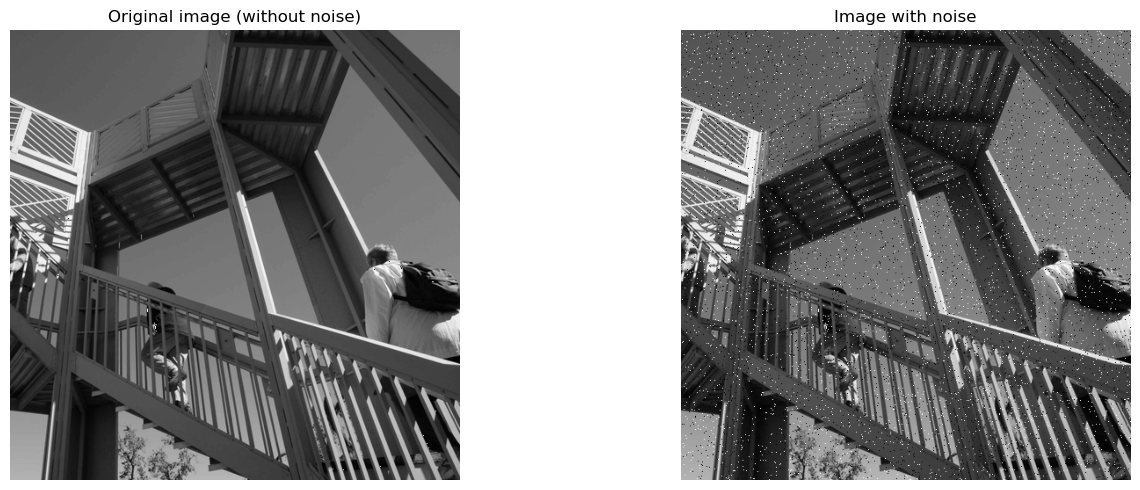

In [975]:
import random 
import cv2 
  
def add_noise(img,noise_level): 
  
    noisy_img = np.copy(img)
    # Getting the dimensions of the image 
    row , col = noisy_img.shape 
      
    # Randomly pick some pixels in the 
    # image for coloring them white 
    # Pick a random number between 300 and 10000 
    number_of_pixels = noise_level
    for i in range(number_of_pixels): 
        
        # Pick a random y coordinate 
        y_coord=random.randint(0, row - 1) 
          
        # Pick a random x coordinate 
        x_coord=random.randint(0, col - 1) 
          
        # Color that pixel to white 
        noisy_img[y_coord][x_coord] = 255
          
    # Randomly pick some pixels in 
    # the image for coloring them black 
    # Pick a random number between 300 and 10000 
    number_of_pixels = noise_level
    for i in range(number_of_pixels): 
        
        # Pick a random y coordinate 
        y_coord=random.randint(0, row - 1) 
          
        # Pick a random x coordinate 
        x_coord=random.randint(0, col - 1) 
          
        # Color that pixel to black 
        noisy_img[y_coord][x_coord] = 0
          
    return noisy_img 
  

'''Generating input :'''
xsharp = misc.ascent()
xsharp = xsharp.astype(np.float32) #create image
'''Add Noise'''
(N1,N2) = np.shape(xsharp)
#noiselevel = 20
noised_image = add_noise(xsharp,4000)

# Create a figure with a row of 3 subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))


axs[0].imshow(xsharp, cmap='gray')
axs[0].set_title('Original image (without noise)')

# Display each image in a subplot
axs[1].imshow(noised_image, cmap='gray')
axs[1].set_title('Image with noise')

# Remove axes for a cleaner look

for ax in axs:
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

We will now compare the two implementations at our disposal in the case of this image. Using the parameters $\lambda = 25, \gamma= \frac{1.9}{8}$ and $\alpha = 20$ as a first try, we run :
- The original Chambolle once
- The revised Chambolle twice : Once with $\alpha=0$ and the second with $\alpha=10$. This is done to check that the case $\alpha=0$ indeed yields the same results as the original Chambolle.

<div class="alert alert-block alert-success"> C'est un peu le bordel au niveau nom des variables, mais quand je dis "[...]_nolasso" c'est pour \alpha = 0, donc sans l'anisotropic term, et donc "[...]_lasso" quand alpha est différent de 0.  </div>

In [953]:
Lambda = 25 
gamma = 1.9/8 # we must have 0 < gamma < 2/8
nbiter = 400
alpha = 10

original_denoised_image,original_ep_array,original_ed_array  = original_chambolle_algorithm(noised_image,Lambda,gamma,nbiter)
denoised_image_nolasso,alphazero_ep_array,alphazero_ed_array  = chambolle_algorithm(noised_image,Lambda,gamma,0,nbiter)
denoised_image_lasso,alpha_ep_array,alpha_ed_array = chambolle_algorithm(noised_image,Lambda,gamma,alpha,nbiter)

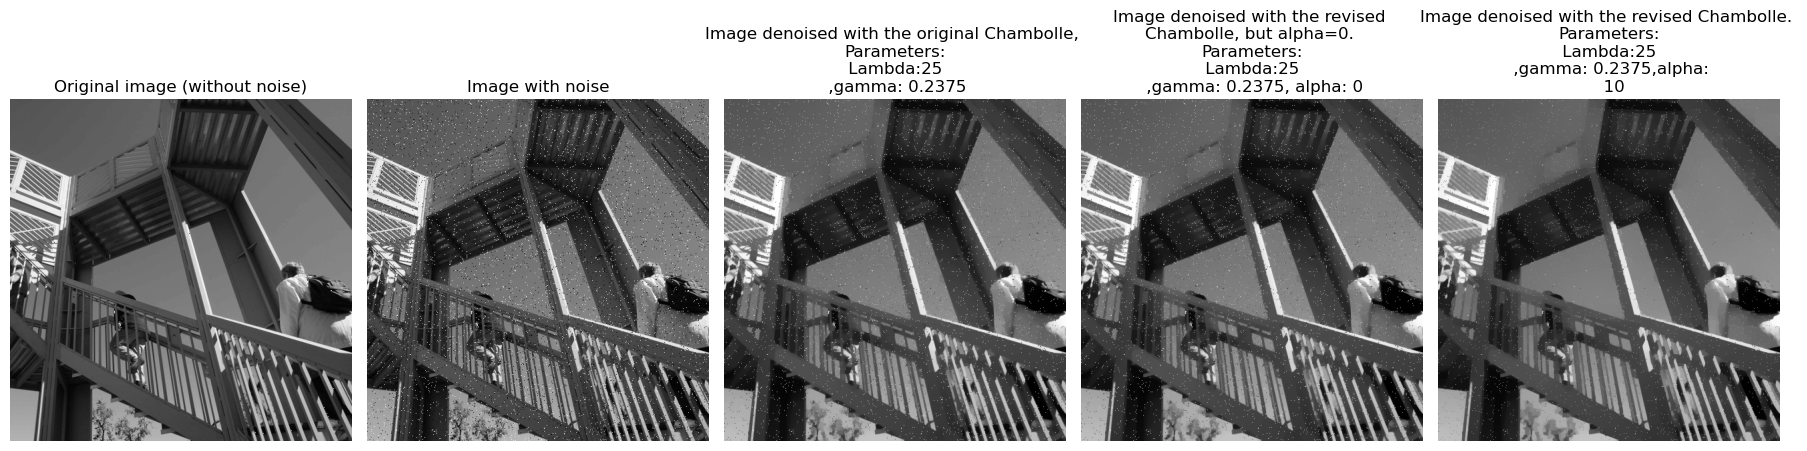

PSNR of the noisy image: 20.271307717344406
PSNR for original Chambolle: 23.90210945201334
PSNR for revised version with alpha = 0 : 23.90210945201334


In [960]:
# Create a figure with a row of 3 subplots
fig, axs = plt.subplots(1, 5, figsize=(18, 5))


axs[0].imshow(xsharp, cmap='gray')
axs[0].set_title('Original image (without noise)')

# Display each image in a subplot
axs[1].imshow(noised_image, cmap='gray')
axs[1].set_title('Image with noise')

axs[2].imshow(original_denoised_image, cmap='gray')
axs[2].set_title(f"Image denoised with the original Chambolle, \nParameters:\n Lambda:{Lambda} \n ,gamma: {gamma}")

axs[3].imshow(denoised_image_nolasso, cmap='gray')
axs[3].set_title(f"Image denoised with the revised \nChambolle, but alpha=0. \nParameters:\n Lambda:{Lambda} \n ,gamma: {gamma}, alpha: {0}")

axs[4].imshow(denoised_image_lasso, cmap='gray')
axs[4].set_title(f"Image denoised with the revised Chambolle. \nParameters:\n Lambda:{Lambda} \n ,gamma: {gamma},alpha:\n  {alpha}")


# Remove axes for a cleaner look

for ax in axs:
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

def calculate_psnr(img1, img2, max_value=255):
    img1 = np.asarray(img1, dtype=np.float32)
    img2 = np.asarray(img2, dtype=np.float32)
    
    if img1.shape != img2.shape:
        raise ValueError(f"Input images must have the same dimensions: img1.shape = {img1.shape}, img2.shape = {img2.shape}")
    
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / np.sqrt(mse))

noisy_image_psnr = calculate_psnr(xsharp, noised_image)
original_chambolle_psnr = calculate_psnr(xsharp, original_denoised_image)
alphazero_psnr = calculate_psnr(xsharp, denoised_image_nolasso)

print("PSNR of the noisy image:", noisy_image_psnr)
print("PSNR for original Chambolle:", original_chambolle_psnr)
print("PSNR for revised version with alpha = 0 :", alphazero_psnr)

The images 3 & 4 (from left to right) above seem to indicate that our revised implementation of Chambolle's algorithm with $\alpha= 0$ and the original Chambolle lead to the same denoised image. Moreover, we can see that adding the $\alpha$ parameter and thus, the new term we added in our primal problem, have an impact on the denoising result. Namely, from what we can see here,  the image is a bit more blurred, due to what seems like a smoothing of the different textures. 

##### Are the original Chambolle and revised Chambolle with $\alpha=0$ the same?

Keeping the investigation on the exact importance of the $\alpha$ parameter for later, let us first focus on comparing our $\alpha = 0$ setting to the original Chambolle. More specifically, let us take a look at the Primal and Dual energies resulting from the iterations :

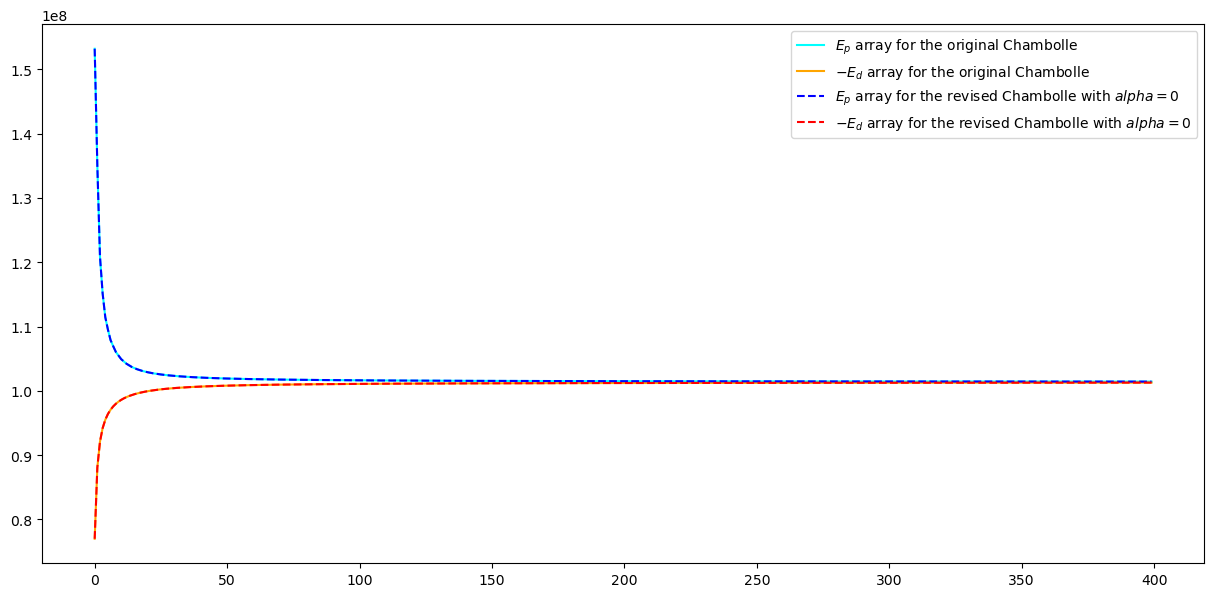

In [961]:
plt.figure(figsize=(15,7))

plt.plot(original_ep_array, color='cyan', label='$E_p$ array for the original Chambolle')
plt.plot(-original_ed_array, color='orange', label='$-E_d$ array for the original Chambolle')

plt.plot(alphazero_ep_array, color='b', linestyle='--', label='$E_p$ array for the revised Chambolle with $alpha=0$')
plt.plot(-alphazero_ed_array, color='r', linestyle='--', label='$-E_d$ array for the revised Chambolle with $alpha=0$')
plt.legend()

plt.show()

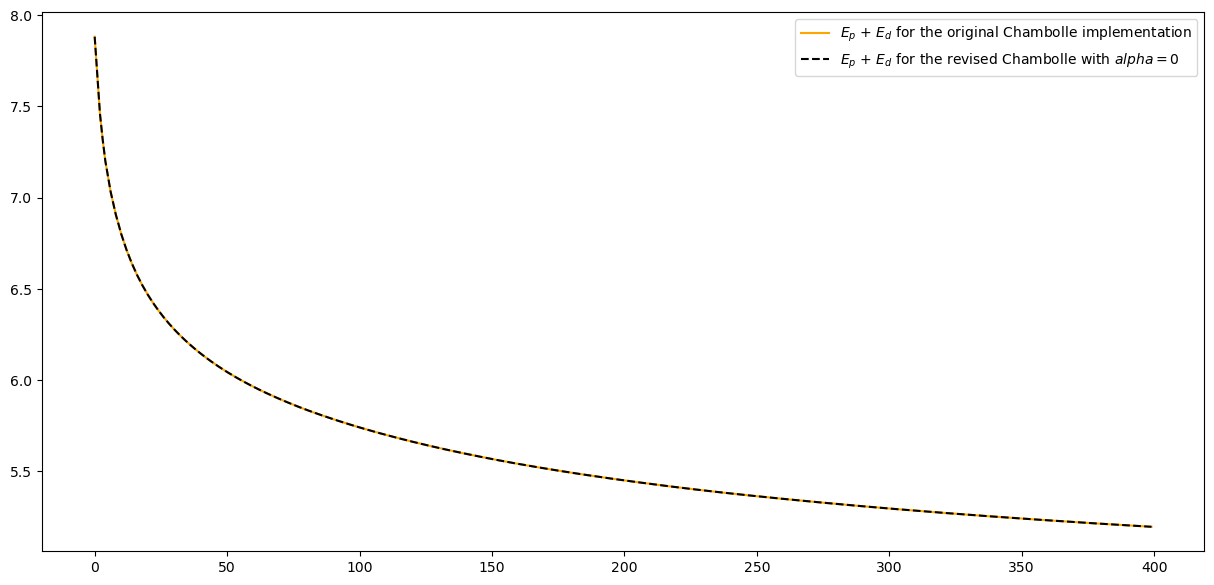

In [962]:
plt.figure(figsize=(15,7))
plt.plot(np.log10(original_ep_array+original_ed_array),color='orange', label='$E_p$ + $E_d$ for the original Chambolle implementation')
plt.plot(np.log10(alphazero_ep_array+alphazero_ed_array),color='black', linestyle='--', label='$E_p$ + $E_d$ for the revised Chambolle with $alpha=0$')
plt.legend()

plt.show()

We indeed obtain the exact same steps throughout the iterations : the two methods are equal. Does this change anything with respect to the Signal To Noise Ratio (SNR)?

In [959]:
noisy_image_psnr = calculate_psnr(xsharp, noised_image)
original_chambolle_psnr = calculate_psnr(xsharp, original_denoised_image)
alphazero_psnr = calculate_psnr(xsharp, denoised_image_nolasso)

print("PSNR of the noisy image:", noisy_image_psnr)
print("PSNR for original Chambolle:", original_chambolle_psnr)
print("PSNR for revised version with alpha = 0 :", alphazero_psnr)


PSNR of the noisy image: 20.271307717344406
PSNR for original Chambolle: 23.90210945201334
PSNR for revised version with alpha = 0 : 23.90210945201334


The images we obtain after denoising are the exact same. This means that our revised algorithm is most likely correctly implemented ! 

#### Investigating the effect of the addition of the anisotropic term (to our objective primal function) to the denoising problem.

Now that we've confirmed the implementation of the algorithm, let us tackle the effect of the anisotropic term.
In the case of dummy values for our different parameters, on the Lena image, we saw a slight blur/smoothing induced by the introduction of the latter. 

With  $\alpha = 0$, i.e original Chambolle, we can see that the denoising is already improving sensitively the PSNR from the noised image. What about with $\alpha = 10$ (the parameter set earlier when generating the images ?)

In [963]:
alpha_psnr = calculate_psnr(xsharp, denoised_image_lasso)

print("PSNR of the image denoised with the revised Chambolle and alpha = 10:", alpha_psnr)

PSNR of the image denoised with the revised Chambolle and alpha = 10: 24.53578205268566


PSNR confirms what can be seen in the image : improves a bit the denoising, PSNR increasing by ~0.5. The original Chambolle performs better than our newly revised algorithm in this specific dummy setup. 

This can lead to the hypothesis that, original Chambolle is 'enough' for the image generated and its level of noise. We can thus ask ourselves what happens when the image is noisier than what it is now ?

In [964]:
new_noiselevel = 45
alpha= 10
Lambda = 25
gamma = 1.9/8 # we must have 0 < gamma < 2/8
nbiter = 400

noisier_image = add_noise(xsharp,15000)

original_noisier_denoised_image,_,_  = original_chambolle_algorithm(noisier_image,Lambda,gamma,nbiter)
denoised_noisier_image_nolasso,_,_  = chambolle_algorithm(noisier_image,Lambda,gamma,0,nbiter)
denoised_noisier_image_lasso,_,_ = chambolle_algorithm(noisier_image,Lambda,gamma,20,nbiter)

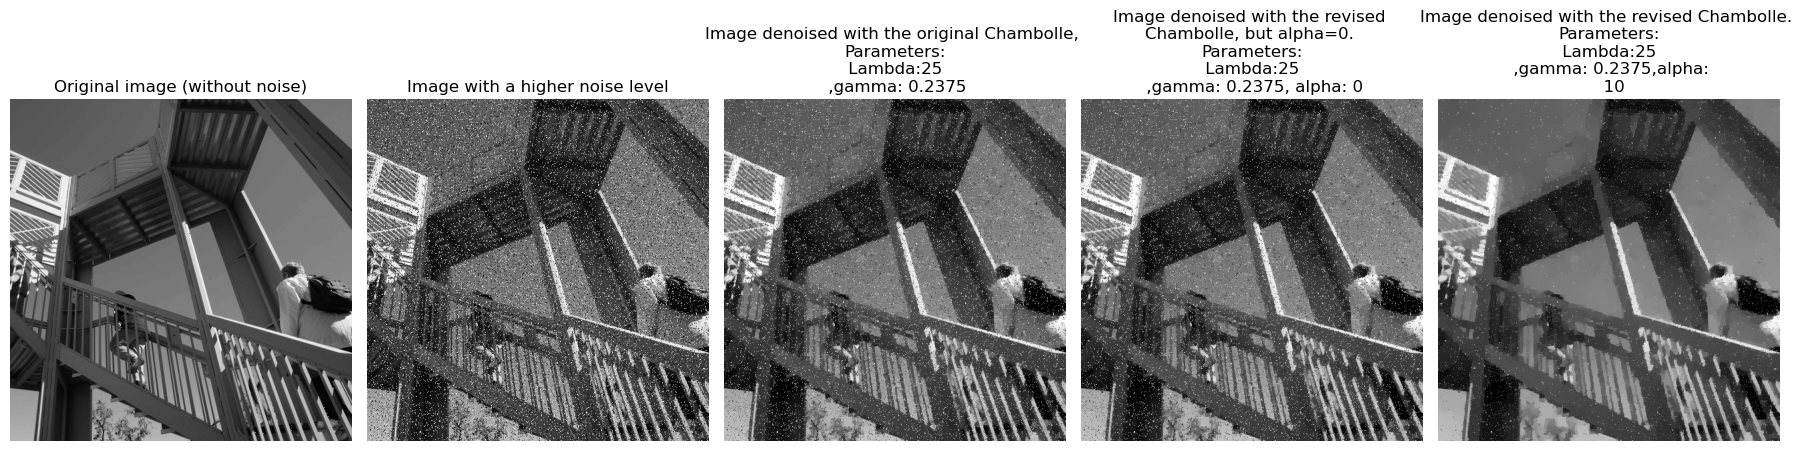

PSNR of the noisy image: 14.790064822251928
PSNR for original Chambolle: 19.463247430898086
PSNR for revised version with alpha = 0 : 19.463247430898086
PSNR of the image denoised with the revised Chambolle and alpha = 10: 22.4629634099915


In [965]:
# Create a figure with a row of 3 subplots
fig, axs = plt.subplots(1, 5, figsize=(18, 5))


axs[0].imshow(xsharp, cmap='gray')
axs[0].set_title('Original image (without noise)')

# Display each image in a subplot
axs[1].imshow(noisier_image, cmap='gray')
axs[1].set_title('Image with a higher noise level')

axs[2].imshow(original_noisier_denoised_image, cmap='gray')
axs[2].set_title(f"Image denoised with the original Chambolle, \nParameters:\n Lambda:{Lambda} \n ,gamma: {gamma}")

axs[3].imshow(denoised_noisier_image_nolasso, cmap='gray')
axs[3].set_title(f"Image denoised with the revised \nChambolle, but alpha=0. \nParameters:\n Lambda:{Lambda} \n ,gamma: {gamma}, alpha: {0}")

axs[4].imshow(denoised_noisier_image_lasso, cmap='gray')
axs[4].set_title(f"Image denoised with the revised Chambolle. \nParameters:\n Lambda:{Lambda} \n ,gamma: {gamma},alpha:\n  {alpha}")


# Remove axes for a cleaner look

for ax in axs:
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

noisier_image_psnr = calculate_psnr(xsharp, noisier_image)
noisier_original_chambolle_psnr = calculate_psnr(xsharp, original_noisier_denoised_image)
noisier_alphazero_psnr = calculate_psnr(xsharp, denoised_noisier_image_nolasso)
noisier_alpha_psnr = calculate_psnr(xsharp, denoised_noisier_image_lasso)

print("PSNR of the noisy image:", noisier_image_psnr)
print("PSNR for original Chambolle:", noisier_original_chambolle_psnr)
print("PSNR for revised version with alpha = 0 :", noisier_alphazero_psnr)
print("PSNR of the image denoised with the revised Chambolle and alpha = 10:", noisier_alpha_psnr)

Interesting result : The PSNR is higher with $\alpha = 10$ compared to the other denoised images, the 'grain' effect coming from the noise seems to be diminished. On its own, it does not mean much tho : it could very well be that setting $\lambda$ is just not 'high enough' for such a noise, and that setting it to a higher value may induce $\alpha$ to become irrelevant.

To further investigate the issue, let us observe the behaviour of the PSNR with varying values of $\lambda$ and $\alpha$, in order to understand better the relationship and the potential trade-off between these two parameters.

#### (Takes 30 mins to run)

In [787]:
alphas = np.linspace(10, 100, 10) 
lambdas = np.linspace(10, 100, 10)  


psnr_values = np.zeros((len(alphas), len(lambdas)))

for i, alpha in enumerate(alphas):
    for j, Lambda in enumerate(lambdas):
        denoised_image_,_,_ = chambolle_algorithm(noisier_image, Lambda, gamma, alpha, nbiter=200)
        psnr = calculate_psnr(xsharp, denoised_image_)
        psnr_values[i, j] = psnr
        #print(f'Alpha: {alpha}, Lambda: {Lambda}, PSNR: {psnr}')

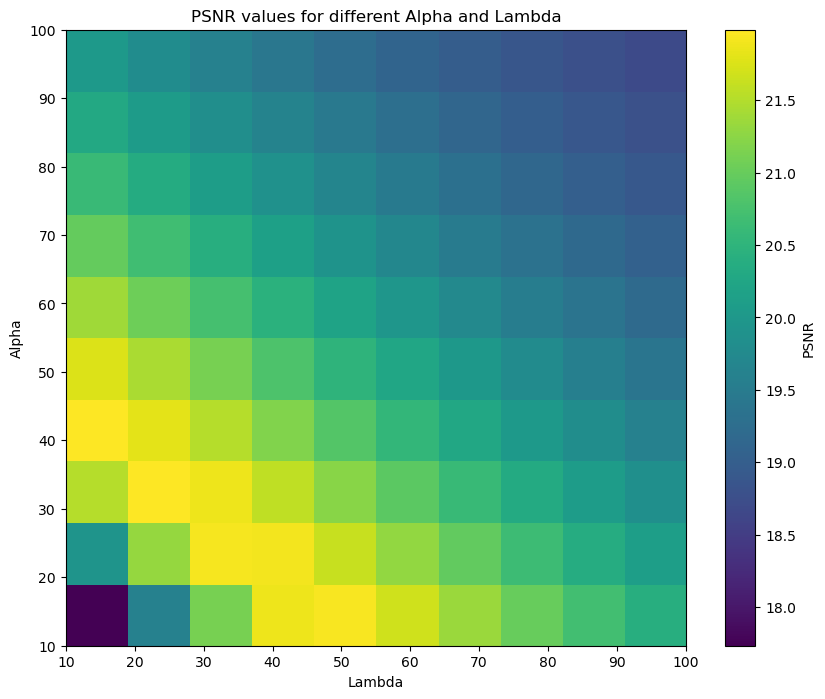

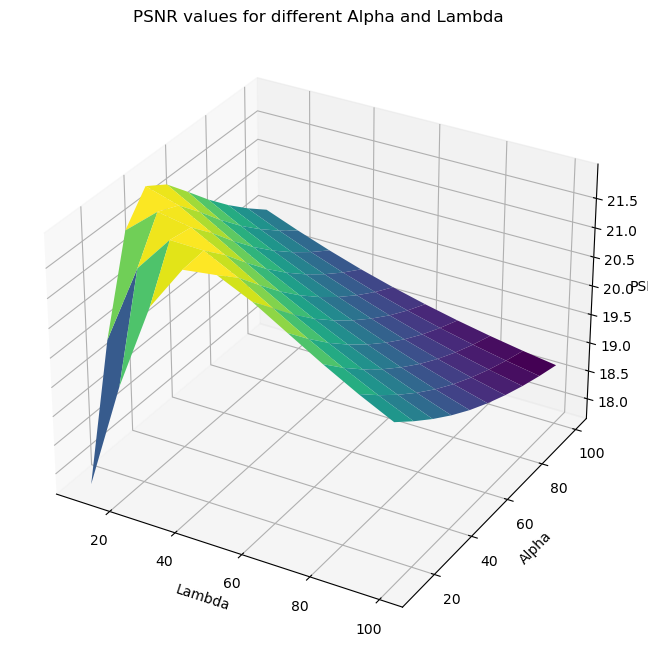

In [789]:
lambdas = np.sort(lambdas)
alphas = np.sort(alphas)

plt.figure(figsize=(10, 8))
plt.imshow(psnr_values, cmap='viridis', aspect='auto', extent=[lambdas[0], lambdas[-1], alphas[0], alphas[-1]], origin='lower')
plt.colorbar(label='PSNR')
plt.xlabel('Lambda')
plt.ylabel('Alpha')
plt.title('PSNR values for different Alpha and Lambda')
plt.show()

# 3D plot of PSNR values
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
L, A = np.meshgrid(lambdas, alphas)
ax.plot_surface(L, A, psnr_values, cmap='viridis')
ax.set_xlabel('Lambda')
ax.set_ylabel('Alpha')
ax.set_zlabel('PSNR')
ax.set_title('PSNR values for different Alpha and Lambda')
plt.show()

Looking at the obtained heatmap(s), higher values of the parameters are not interesting to consider and yield worse PSNR values (for that specific level of noise, that is). Let us perform the same thing, but only considering 'lower' values of our parameters. 

#### (Takes 80 mins to run)

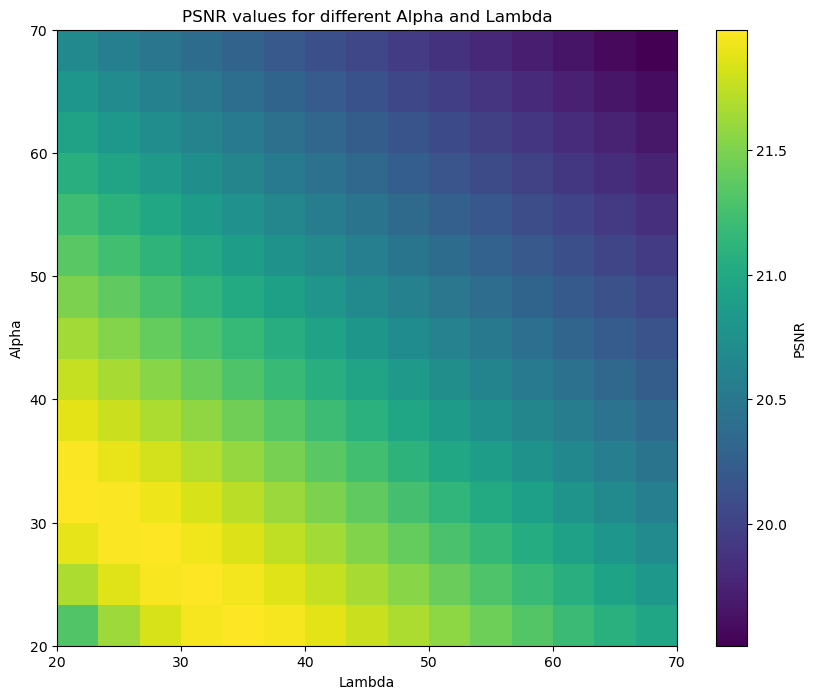

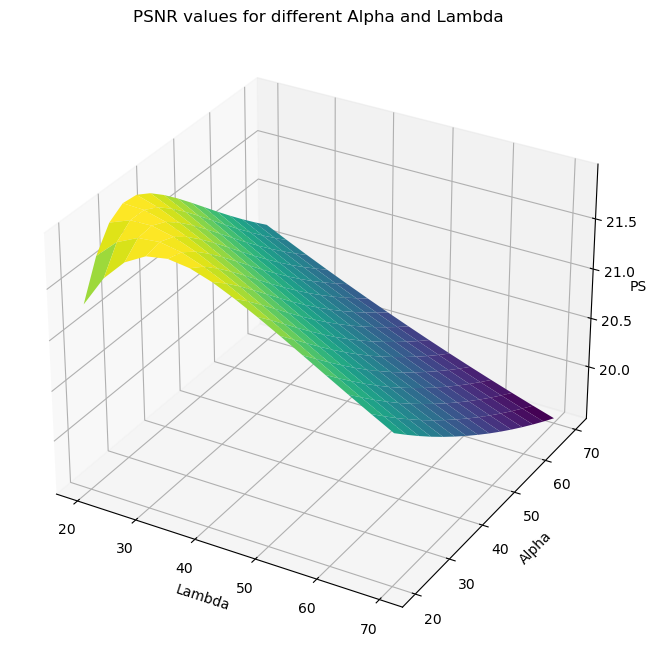

In [790]:
alphas = np.linspace(20, 70, 15) 
lambdas = np.linspace(20, 70, 15)  

psnr_values = np.zeros((len(alphas), len(lambdas)))

for i, alpha in enumerate(alphas):
    for j, Lambda in enumerate(lambdas):
        denoised_image_,_,_ = chambolle_algorithm(noisier_image, Lambda, gamma, alpha, nbiter=200)
        psnr = calculate_psnr(xsharp, denoised_image_)
        psnr_values[i, j] = psnr

plt.figure(figsize=(10, 8))
plt.imshow(psnr_values, cmap='viridis', aspect='auto', extent=[lambdas[0], lambdas[-1], alphas[0], alphas[-1]], origin='lower')
plt.colorbar(label='PSNR')
plt.xlabel('Lambda')
plt.ylabel('Alpha')
plt.title('PSNR values for different Alpha and Lambda')
plt.show()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
L, A = np.meshgrid(lambdas, alphas)
ax.plot_surface(L, A, psnr_values, cmap='viridis')
ax.set_xlabel('Lambda')
ax.set_ylabel('Alpha')
ax.set_zlabel('PSNR')
ax.set_title('PSNR values for different Alpha and Lambda')
plt.show()

Seems to be a "range" of parameters that are optimal : From that heatmap only, it's hard to evaluate the exact effect for $\alpha$ / say if it has an effect at all. It seems like we could set the sum of $\alpha$ and $\lambda$ to be $\in [30,40]$, whatever the individual values are, to get a decent result. 

To elaborate on this, let's look at what these different combinations yield when looking at the actual images.

We thus tackle each of the following cases :

- Using both $\lambda$ and $\alpha$, with 'median' values,
- Only using $\lambda$,
- Only using $\alpha$.



In [799]:
both_psnr_lambda = 28
both_psnr_alpha = 28

onlylambda_psnr_lambda = 57
onlylambda_psnr_alpha = 0

onlyalpha_psnr_lambda = 0.00000001
onlyalpha_psnr_alpha = 57
    
both_denoised,_,_ = chambolle_algorithm(noisier_image,both_psnr_lambda,gamma,both_psnr_alpha,nbiter)
onlylambda_denoised,_,_ = chambolle_algorithm(noisier_image,onlylambda_psnr_lambda,gamma,onlylambda_psnr_alpha,nbiter)
onlyalpha_denoised,_,_ = chambolle_algorithm(noisier_image,onlyalpha_psnr_lambda,gamma,onlyalpha_psnr_alpha,nbiter)

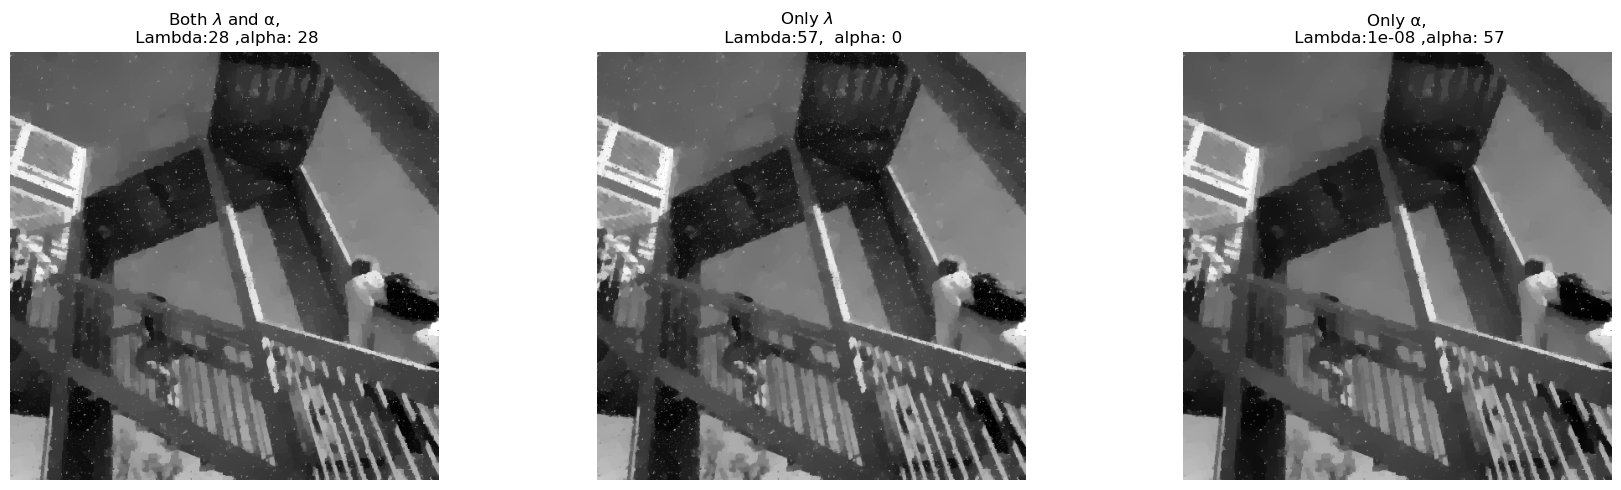

PSNR for both λ & α 21.960312219163093
PSNR only λ and no α 21.993781564442333
PSNR no λ and only α : 21.79599151561201


In [801]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].imshow(both_denoised, cmap='gray')
axs[0].set_title(f"Both $\lambda$ and \u03B1,\n Lambda:{both_psnr_lambda} ,alpha: {both_psnr_alpha}")

axs[1].imshow(onlylambda_denoised, cmap='gray')
axs[1].set_title(f"Only $\lambda$  \n Lambda:{onlylambda_psnr_lambda},  alpha: {onlylambda_psnr_alpha}")

axs[2].imshow(onlyalpha_denoised, cmap='gray')
axs[2].set_title(f"Only \u03B1,\n Lambda:{onlyalpha_psnr_lambda} ,alpha: {onlyalpha_psnr_alpha}")


for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

both_psnr = calculate_psnr(xsharp, both_denoised)
only_lambda_psnr = calculate_psnr(xsharp, onlylambda_denoised)
only_alpha_psnr = calculate_psnr(xsharp, onlyalpha_denoised)

print("PSNR for both \u03BB & \u03B1", both_psnr)
print("PSNR only \u03BB and no \u03B1", only_lambda_psnr)
print("PSNR no \u03BB and only \u03B1 :", only_alpha_psnr)

In terms of PSNR, they are similar and there's only a difference of  ~$0.1$ in absolute. The PSNR for both $\alpha$ and $\lambda \neq 0$ is higher than the two others, but by what can be considered a non-significant margin.

Can this be said for all noise levels ? (We re-do the same thing, but with several noise levels, and varying $\lambda$/$\alpha$ values.)

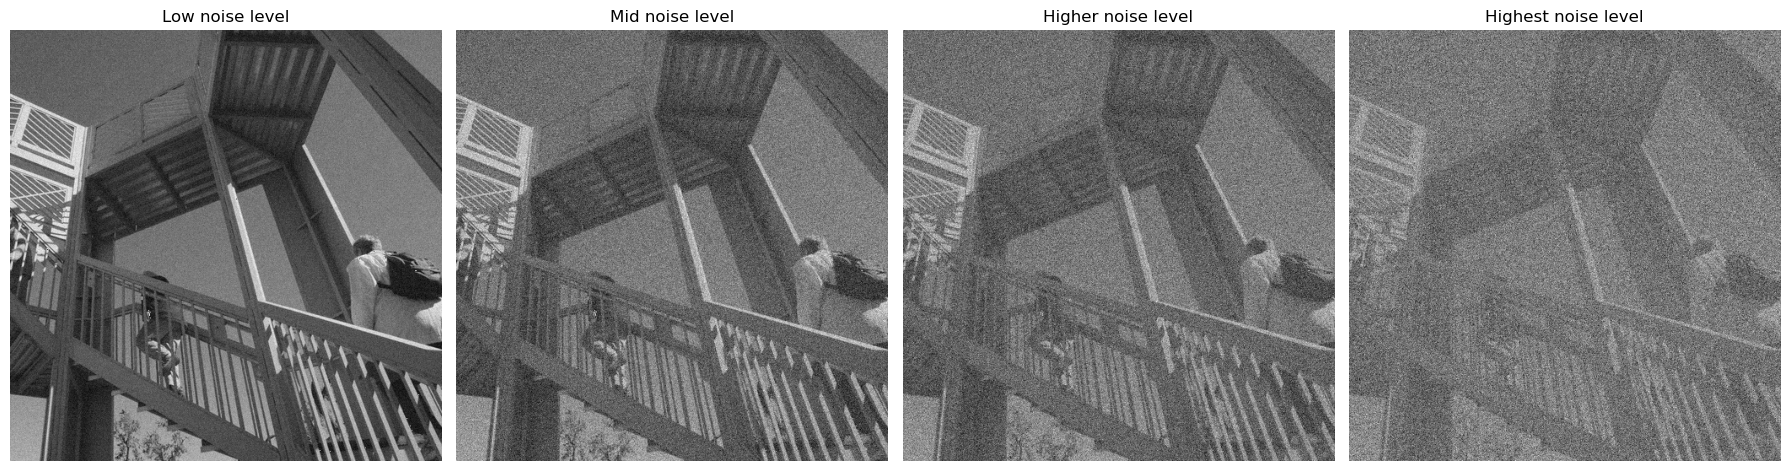

In [457]:
low_noise_level = 10
mid_noise_level = 30
higher_noise_level = 50
highest_noise_level = 100

low_noise_image = xsharp + low_noise_level * np.random.randn(N1,N2)
mid_noise_image = xsharp + mid_noise_level * np.random.randn(N1,N2)
higher_noise_image = xsharp + higher_noise_level * np.random.randn(N1,N2)
highest_noise_image = xsharp + highest_noise_level * np.random.randn(N1,N2)

# Create a figure with a row of 3 subplots
fig, axs = plt.subplots(1, 4, figsize=(18, 5))

axs[0].imshow(low_noise_image, cmap='gray')
axs[0].set_title(f"Low noise level")

axs[1].imshow(mid_noise_image, cmap='gray')
axs[1].set_title(f"Mid noise level")

axs[2].imshow(higher_noise_image, cmap='gray')
axs[2].set_title(f"Higher noise level")

axs[3].imshow(highest_noise_image, cmap='gray')
axs[3].set_title(f"Highest noise level")

for ax in axs:
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

##### Low noise :

In [465]:
low_both_denoised,_,_ = chambolle_algorithm(low_noise_image,10,gamma,10,nbiter)
low_onlylambda_denoised,_,_ = chambolle_algorithm(low_noise_image,20,gamma,0,nbiter)
low_onlyalpha_denoised,_,_ = chambolle_algorithm(low_noise_image,0,gamma,20,nbiter)

C:\Users\dryha\AppData\Local\Temp\ipykernel_26920\1176656996.py:2: RuntimeWarning: divide by zero encountered in divide
  return u/np.tile(np.maximum(np.sqrt(np.sum(u**2,2,keepdims=True))/Lambda,1),(1,1,2)) # soft-thresholding
C:\Users\dryha\AppData\Local\Temp\ipykernel_26920\1176656996.py:2: RuntimeWarning: invalid value encountered in divide
  return u/np.tile(np.maximum(np.sqrt(np.sum(u**2,2,keepdims=True))/Lambda,1),(1,1,2)) # soft-thresholding


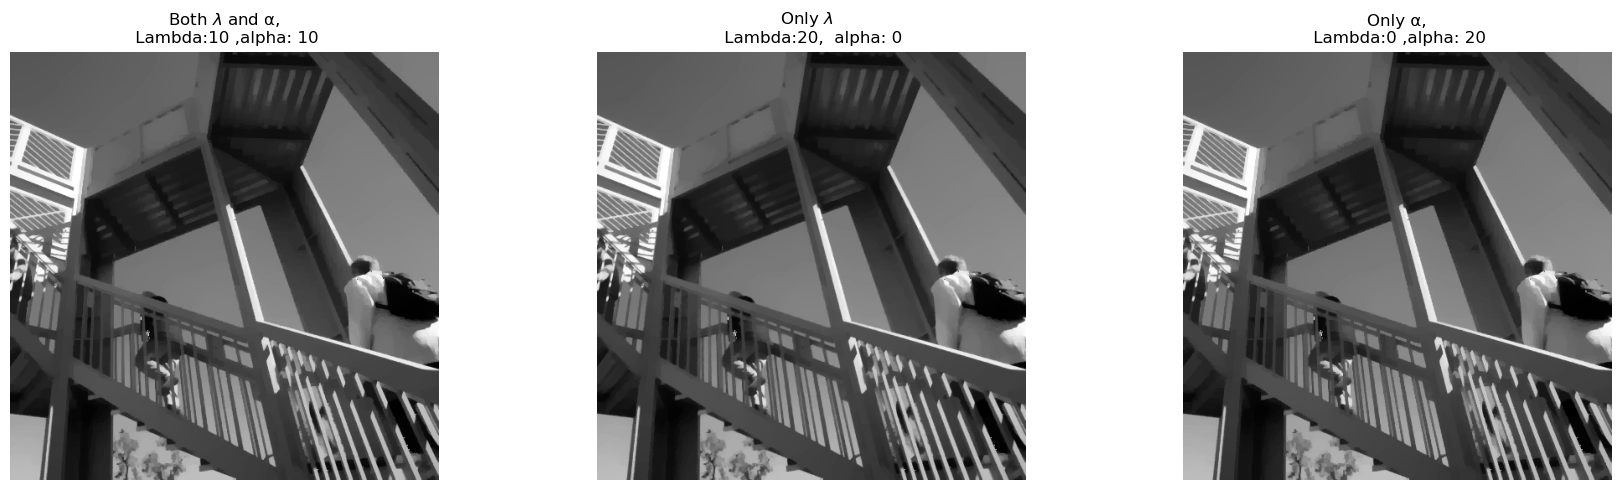

PSNR for both λ & α 29.044269269505175
PSNR only λ and no α 29.45913304681025
PSNR no λ and only α : 28.553893885946742


In [466]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].imshow(low_both_denoised, cmap='gray')
axs[0].set_title(f"Both $\lambda$ and \u03B1,\n Lambda:{10} ,alpha: {10}")

axs[1].imshow(low_onlylambda_denoised, cmap='gray')
axs[1].set_title(f"Only $\lambda$  \n Lambda:{20},  alpha: {0}")

axs[2].imshow(low_onlyalpha_denoised, cmap='gray')
axs[2].set_title(f"Only \u03B1,\n Lambda:{0} ,alpha: {20}")


for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

both_psnr = calculate_psnr(xsharp, low_both_denoised)
only_lambda_psnr = calculate_psnr(xsharp, low_onlylambda_denoised)
only_alpha_psnr = calculate_psnr(xsharp, low_onlyalpha_denoised)

print("PSNR for both \u03BB & \u03B1", both_psnr)
print("PSNR only \u03BB and no \u03B1", only_lambda_psnr)
print("PSNR no \u03BB and only \u03B1 :", only_alpha_psnr)

##### Mid noise :

In [512]:
mid_both_denoised,_,_ = chambolle_algorithm(mid_noise_image,20,gamma,20,nbiter)
mid_onlylambda_denoised,_,_ = chambolle_algorithm(mid_noise_image,40,gamma,0,nbiter)
mid_onlyalpha_denoised,_,_ = chambolle_algorithm(mid_noise_image,0,gamma,40,nbiter)

C:\Users\dryha\AppData\Local\Temp\ipykernel_26920\1176656996.py:2: RuntimeWarning: divide by zero encountered in divide
  return u/np.tile(np.maximum(np.sqrt(np.sum(u**2,2,keepdims=True))/Lambda,1),(1,1,2)) # soft-thresholding
C:\Users\dryha\AppData\Local\Temp\ipykernel_26920\1176656996.py:2: RuntimeWarning: invalid value encountered in divide
  return u/np.tile(np.maximum(np.sqrt(np.sum(u**2,2,keepdims=True))/Lambda,1),(1,1,2)) # soft-thresholding


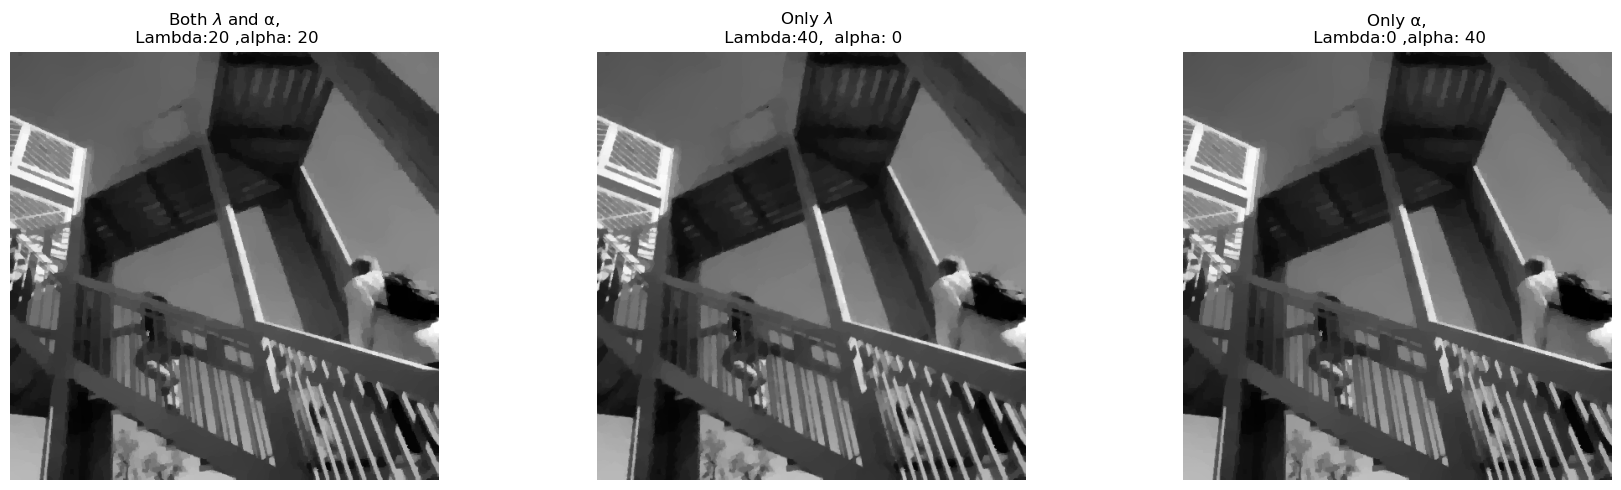

PSNR for both λ & α 25.402399705801336
PSNR only λ and no α 25.710354059354962
PSNR no λ and only α : 25.02284667694719


In [471]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].imshow(mid_both_denoised, cmap='gray')
axs[0].set_title(f"Both $\lambda$ and \u03B1,\n Lambda:{20} ,alpha: {20}")

axs[1].imshow(mid_onlylambda_denoised, cmap='gray')
axs[1].set_title(f"Only $\lambda$  \n Lambda:{40},  alpha: {0}")

axs[2].imshow(mid_onlyalpha_denoised, cmap='gray')
axs[2].set_title(f"Only \u03B1,\n Lambda:{0} ,alpha: {40}")


for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

both_psnr = calculate_psnr(xsharp, mid_both_denoised)
only_lambda_psnr = calculate_psnr(xsharp, mid_onlylambda_denoised)
only_alpha_psnr = calculate_psnr(xsharp, mid_onlyalpha_denoised)

print("PSNR for both \u03BB & \u03B1", both_psnr)
print("PSNR only \u03BB and no \u03B1", only_lambda_psnr)
print("PSNR no \u03BB and only \u03B1 :", only_alpha_psnr)

##### Higher noise :

In [476]:
high_both_denoised,_,_ = chambolle_algorithm(higher_noise_image,40,gamma,40,nbiter)
high_onlylambda_denoised,_,_ = chambolle_algorithm(higher_noise_image,80,gamma,0,nbiter)
high_onlyalpha_denoised,_,_ = chambolle_algorithm(higher_noise_image,0,gamma,80,nbiter)

C:\Users\dryha\AppData\Local\Temp\ipykernel_26920\1176656996.py:2: RuntimeWarning: divide by zero encountered in divide
  return u/np.tile(np.maximum(np.sqrt(np.sum(u**2,2,keepdims=True))/Lambda,1),(1,1,2)) # soft-thresholding
C:\Users\dryha\AppData\Local\Temp\ipykernel_26920\1176656996.py:2: RuntimeWarning: invalid value encountered in divide
  return u/np.tile(np.maximum(np.sqrt(np.sum(u**2,2,keepdims=True))/Lambda,1),(1,1,2)) # soft-thresholding


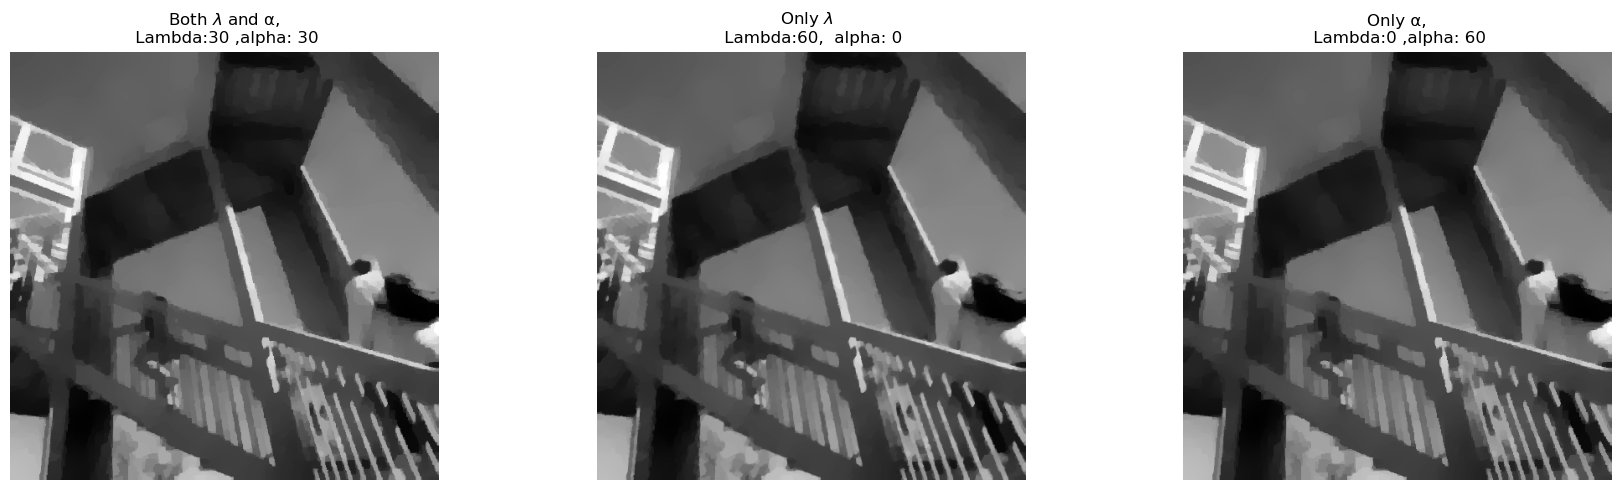

PSNR for both λ & α 22.776647395941502
PSNR only λ and no α 23.018098342089903
PSNR no λ and only α : 22.4603058832834


In [477]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].imshow(high_both_denoised, cmap='gray')
axs[0].set_title(f"Both $\lambda$ and \u03B1,\n Lambda:{30} ,alpha: {30}")

axs[1].imshow(high_onlylambda_denoised, cmap='gray')
axs[1].set_title(f"Only $\lambda$  \n Lambda:{60},  alpha: {0}")

axs[2].imshow(high_onlyalpha_denoised, cmap='gray')
axs[2].set_title(f"Only \u03B1,\n Lambda:{0} ,alpha: {60}")


for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

both_psnr = calculate_psnr(xsharp, high_both_denoised)
only_lambda_psnr = calculate_psnr(xsharp, high_onlylambda_denoised)
only_alpha_psnr = calculate_psnr(xsharp, high_onlyalpha_denoised)

print("PSNR for both \u03BB & \u03B1", both_psnr)
print("PSNR only \u03BB and no \u03B1", only_lambda_psnr)
print("PSNR no \u03BB and only \u03B1 :", only_alpha_psnr)

On the ascent image, whatever the noise level is, it does not seem like adding alpha improves the quality of the PSNR compared to cases where only $\alpha$ / $\lambda$ is present.

### Trying out SaP noise reduction on a synthetic test image

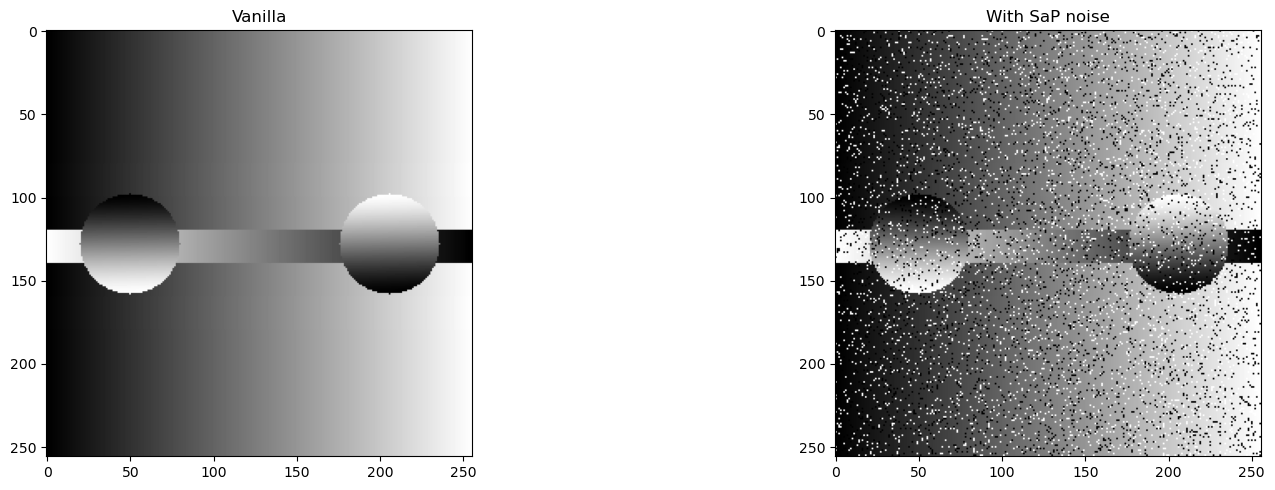

In [985]:
#xsharp = color.rgb2gray(io.imread(CBSD68_PATH +'noisy15/0032.png'))
#noisy15_img = color.rgb2gray(io.imread(CBSD68_PATH +'noisy35/0010.png'))
#xsharp = gradient_image
#xsharp = misc.ascent()
#xsharp = xsharp.astype(np.float32) #create image


def create_test_pattern():
    img = np.zeros((256, 256))

    # Add vertical gradient
    for i in range(img.shape[1]):
        img[:, i] = i / img.shape[1]

    # Add horizontal stripes
    img[80:100, :] = np.linspace(0, 1, img.shape[1])
    img[120:140, :] = np.linspace(1, 0, img.shape[1])
    img[160:180, :] = np.linspace(0, 1, img.shape[1])

    # Add circles
    y, x = np.ogrid[:256, :256]
    mask1 = (x - 50)**2 + (y - 128)**2 <= 30**2
    mask2 = (x - 206)**2 + (y - 128)**2 <= 30**2
    img[mask1] = np.linspace(0, 1, np.count_nonzero(mask1))
    img[mask2] = np.linspace(1, 0, np.count_nonzero(mask2))

    img = (img * 255).astype(np.uint8)

    return img

pattern = create_test_pattern()
x_noise = add_noise(pattern,4000)

fig, axs = plt.subplots(1, 2, figsize=(18, 5))

axs[0].imshow(pattern, cmap='gray')
axs[0].set_title(f"Vanilla")

axs[1].imshow(x_noise,cmap='gray')
axs[1].set_title(f"With SaP noise")
plt.tight_layout()
plt.show()

#plt.imshow(x_noise,cmap='gray')
#print(np.shape(D(x_noise)))
#aniso = 0
#iso = 0
#dx = D(x_noise)
#
#for i in range(np.shape(dx)[1]):
#    for j in range((np.shape(dx)[0])):
#        aniso += np.sqrt(dx[j, i, 1]**2 + dx[j, i, 0]**2)
#        iso += abs(dx[j, i, 1]) + abs(dx[j, i, 0])
#
#print("iso: " + str(iso))
#print("aniso: " + str(aniso))
#print("factor: " + str(iso/aniso))

In [992]:
high_both_denoised,_,_ = chambolle_algorithm(x_noise,30,gamma,30,nbiter)
high_onlylambda_denoised,_,_ = chambolle_algorithm(x_noise,60,gamma,0,nbiter)
high_onlyalpha_denoised,_,_ = chambolle_algorithm(x_noise,0.000000000000001,gamma,60,nbiter)

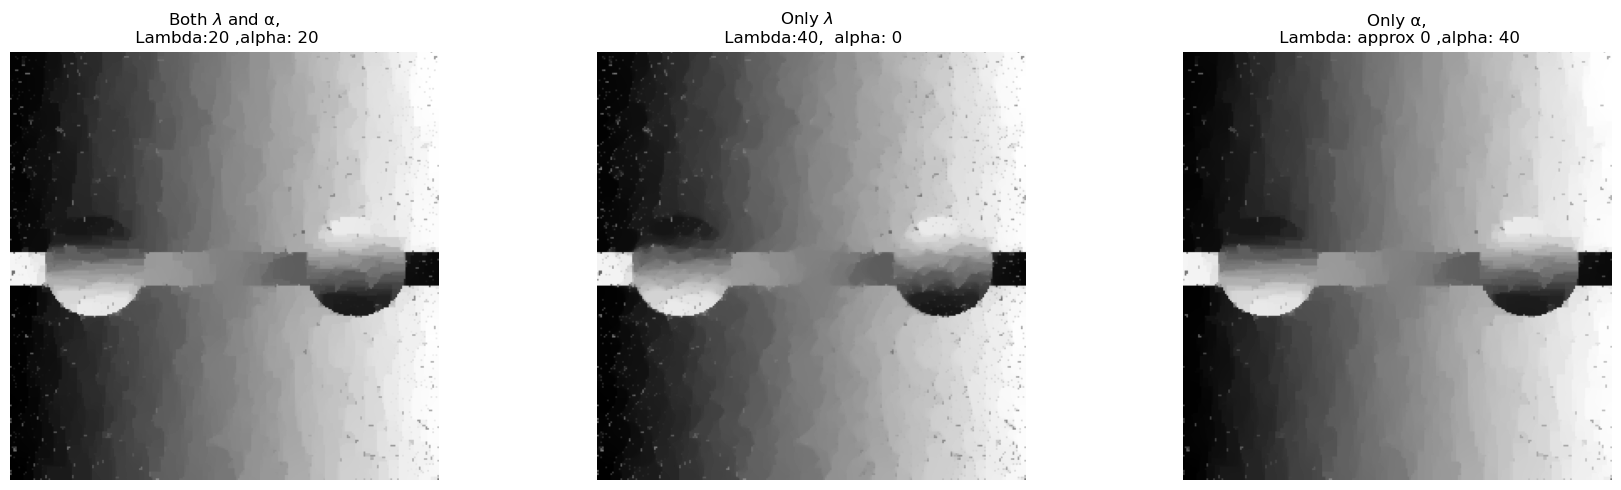

In [993]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].imshow(high_both_denoised, cmap='gray')
axs[0].set_title(f"Both $\lambda$ and \u03B1,\n Lambda:{20} ,alpha: {20}")

axs[1].imshow(high_onlylambda_denoised, cmap='gray')
axs[1].set_title(f"Only $\lambda$  \n Lambda:{40},  alpha: {0}")

axs[2].imshow(high_onlyalpha_denoised, cmap='gray')
axs[2].set_title(f"Only \u03B1,\n Lambda: approx {0} ,alpha: {40}")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

Different in 'texture' : less smoothed when considering only the isotropic term or addition of both TVs 

### Random bullshit to zoom on images to try and see differences

In [881]:
from scipy.ndimage import zoom


def clipped_zoom(img, zoom_factor, **kwargs):

    h, w = img.shape[:2]

    # For multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # Zooming out
    if zoom_factor < 1:

        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        # Zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, **kwargs)

    # Zooming in
    elif zoom_factor > 1:

        # Bounding box of the zoomed-in region within the input array
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)

        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # If zoom_factor == 1, just return the input array
    else:
        out = img
    return out

zm1 = clipped_zoom(high_both_denoised, 2.05)
zm2 = clipped_zoom(high_onlylambda_denoised, 2.05)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(zm1,cmap='gray')
ax[1].imshow(zm2,cmap='gray')

### CBSD68 Color Dataset 

# Pas encore push sur le git, je ferai ça demain / rappelle le moi si c'est pas fait

Testing out the results on the benchmark CBSD68 Color dataset, containing 68 colored original images and corrupted versions with gaussian noise levels $\in [5,10,15,25,35,50]$ for each of the originals.

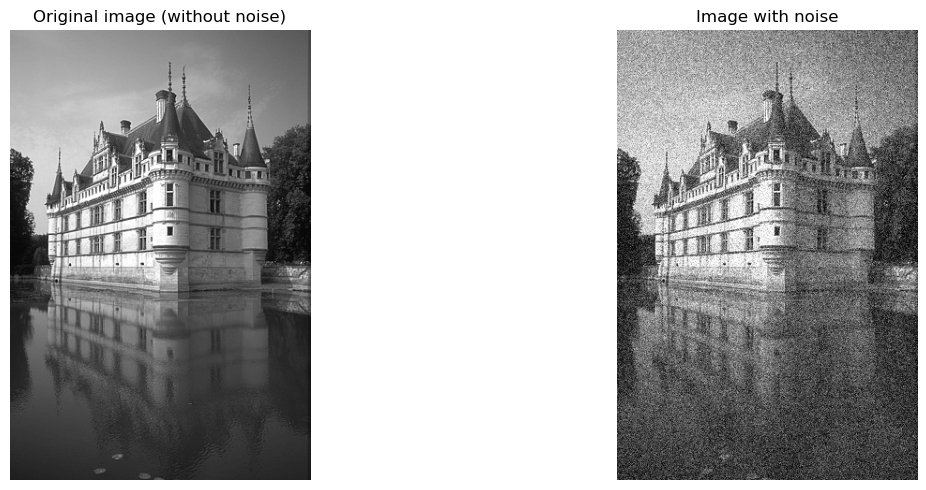

In [669]:
import matplotlib.image as mpimg

CBSD68_PATH = '../CBSD68/'


from skimage import color
from skimage import io

img = color.rgb2gray(io.imread(CBSD68_PATH +'original_png/0010.png'))
noisy15_img = color.rgb2gray(io.imread(CBSD68_PATH +'noisy35/0010.png'))


# Create a figure with a row of 3 subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))


axs[0].imshow(img,cmap='gray')
axs[0].set_title('Original image (without noise)')

# Display each image in a subplot
axs[1].imshow(noisy15_img,cmap='gray')
axs[1].set_title('Image with noise')

# Remove axes for a cleaner look

for ax in axs:
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

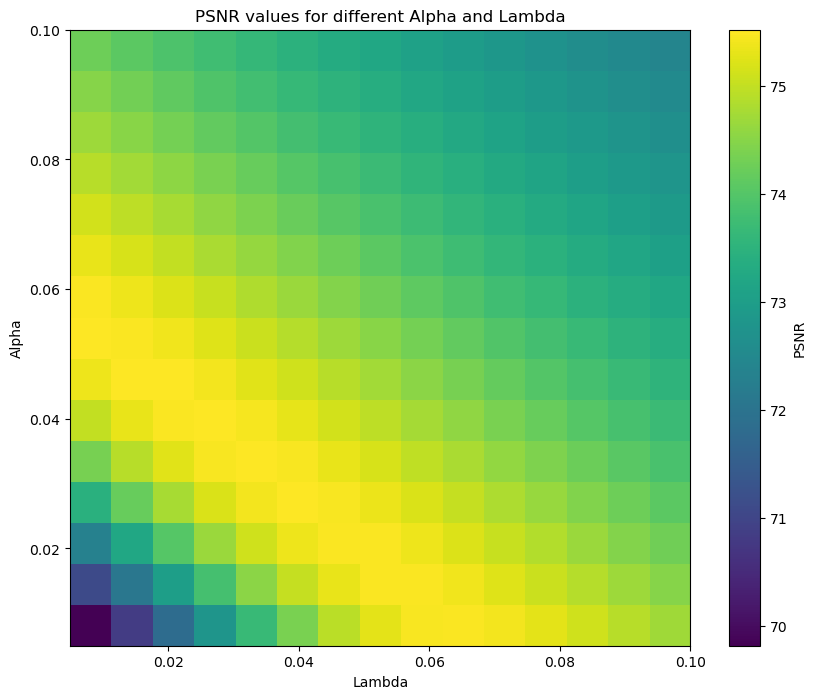

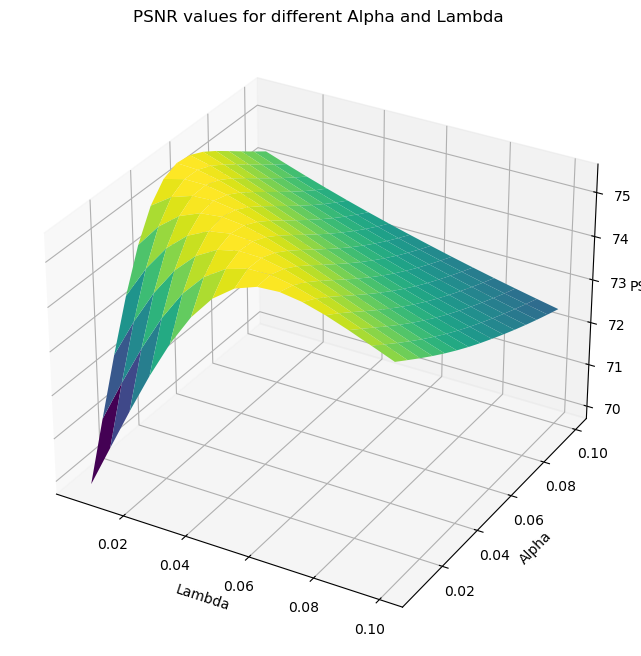

In [670]:
alphas = np.linspace(0.005, 0.1, 15) 
lambdas = np.linspace(0.005, 0.1, 15)  

psnr_values = np.zeros((len(alphas), len(lambdas)))

for i, alpha in enumerate(alphas):
    for j, Lambda in enumerate(lambdas):
        denoised_image_,_,_ = chambolle_algorithm(noisy15_img, Lambda, gamma, alpha, nbiter=200)
        psnr = calculate_psnr(img, denoised_image_)
        psnr_values[i, j] = psnr

plt.figure(figsize=(10, 8))
plt.imshow(psnr_values, cmap='viridis', aspect='auto', extent=[lambdas[0], lambdas[-1], alphas[0], alphas[-1]], origin='lower')
plt.colorbar(label='PSNR')
plt.xlabel('Lambda')
plt.ylabel('Alpha')
plt.title('PSNR values for different Alpha and Lambda')
plt.show()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
L, A = np.meshgrid(lambdas, alphas)
ax.plot_surface(L, A, psnr_values, cmap='viridis')
ax.set_xlabel('Lambda')
ax.set_ylabel('Alpha')
ax.set_zlabel('PSNR')
ax.set_title('PSNR values for different Alpha and Lambda')
plt.show()

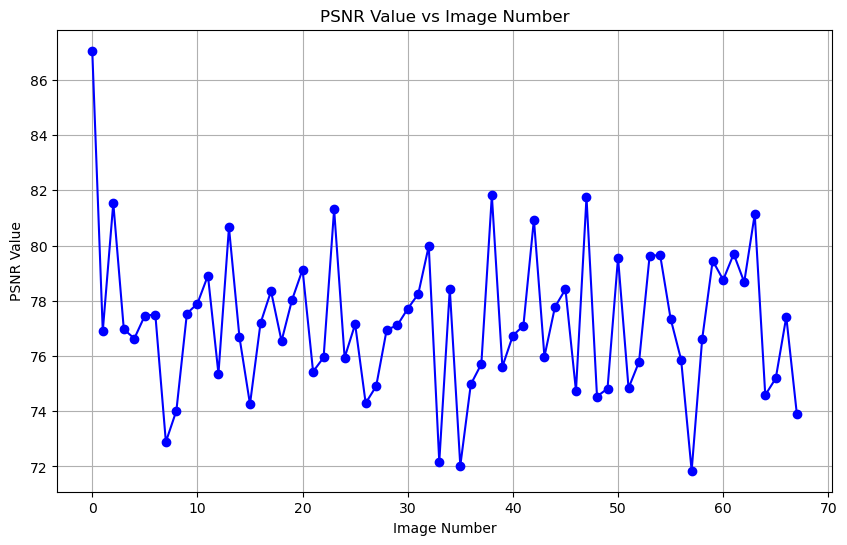

In [681]:
import os
from os import listdir
from os.path import isfile, join


onlyfiles = [f for f in listdir(CBSD68_PATH+'/noisy15') if isfile(join(CBSD68_PATH+'/noisy15', f))]

psnr_values = []
image_indices = []

for idx, IMG_NAME in enumerate(onlyfiles):

    img = color.rgb2gray(io.imread(os.path.join(CBSD68_PATH+'/original_png/', IMG_NAME)))
    noisy_img = color.rgb2gray(io.imread(os.path.join(CBSD68_PATH+'/noisy15/', IMG_NAME)))
    
    denoised_image,_,_ = chambolle_algorithm(noisy_img, 0.02, gamma, 0.03, nbiter=200)
    
    psnr_value = calculate_psnr(img, denoised_image)

    psnr_values.append(psnr_value)
    image_indices.append(idx)  
    

plt.figure(figsize=(10, 6))
plt.plot(image_indices, psnr_values, marker='o', linestyle='-', color='b')
plt.title('PSNR Value vs Image Number')
plt.xlabel('Image Number')
plt.ylabel('PSNR Value')
plt.grid(True)
plt.show()

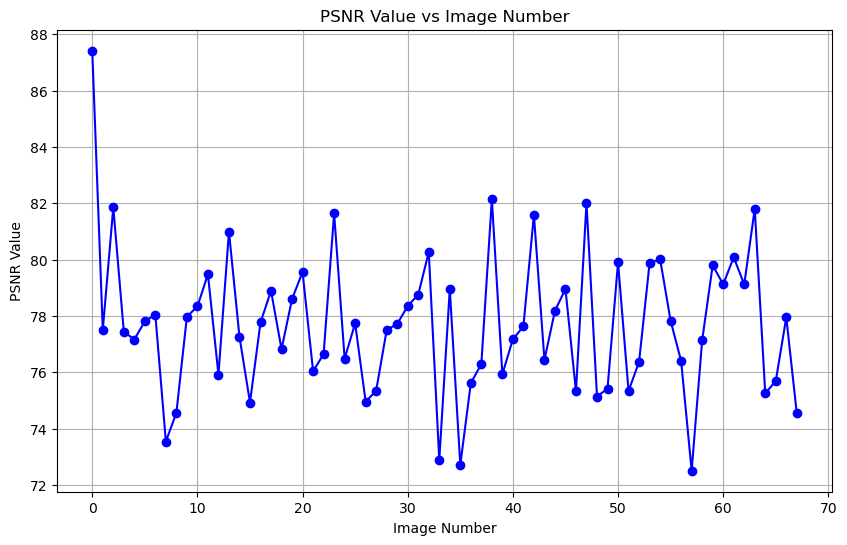

In [683]:
import os
from os import listdir
from os.path import isfile, join


onlyfiles = [f for f in listdir(CBSD68_PATH+'/noisy15') if isfile(join(CBSD68_PATH+'/noisy15', f))]

psnr_values = []
image_indices = []

for idx, IMG_NAME in enumerate(onlyfiles):

    img = color.rgb2gray(io.imread(os.path.join(CBSD68_PATH+'/original_png/', IMG_NAME)))
    noisy_img = color.rgb2gray(io.imread(os.path.join(CBSD68_PATH+'/noisy15/', IMG_NAME)))
    
    denoised_image, _, _ = chambolle_algorithm(noisy_img, 0.05, gamma, 0, nbiter=200)
    
    psnr_value = calculate_psnr(img, denoised_image)

    psnr_values.append(psnr_value)
    image_indices.append(idx)  
    

plt.figure(figsize=(10, 6))
plt.plot(image_indices, psnr_values, marker='o', linestyle='-', color='b')
plt.title('PSNR Value vs Image Number')
plt.xlabel('Image Number')
plt.ylabel('PSNR Value')
plt.grid(True)
plt.show()

C:\Users\dryha\AppData\Local\Temp\ipykernel_26920\1176656996.py:2: RuntimeWarning: divide by zero encountered in divide
  return u/np.tile(np.maximum(np.sqrt(np.sum(u**2,2,keepdims=True))/Lambda,1),(1,1,2)) # soft-thresholding
C:\Users\dryha\AppData\Local\Temp\ipykernel_26920\1176656996.py:2: RuntimeWarning: invalid value encountered in divide
  return u/np.tile(np.maximum(np.sqrt(np.sum(u**2,2,keepdims=True))/Lambda,1),(1,1,2)) # soft-thresholding


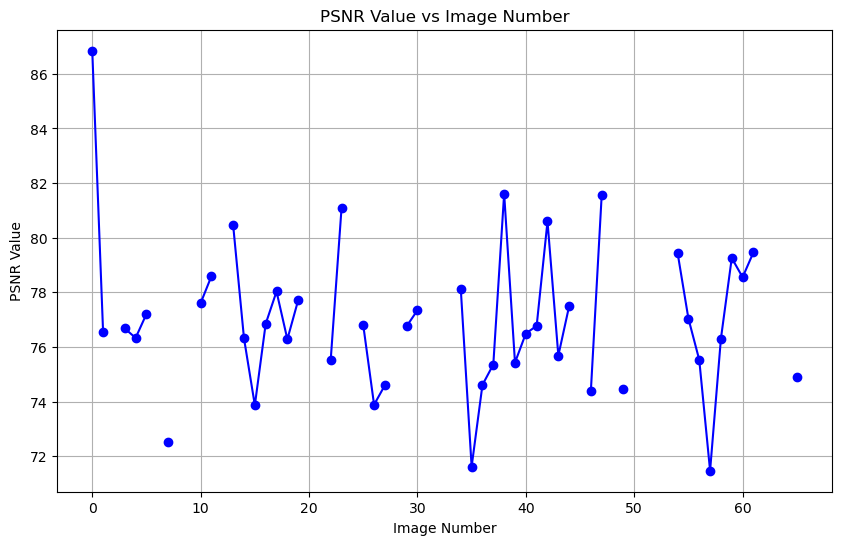

In [684]:
import os
from os import listdir
from os.path import isfile, join


onlyfiles = [f for f in listdir(CBSD68_PATH+'/noisy15') if isfile(join(CBSD68_PATH+'/noisy15', f))]

psnr_values = []
image_indices = []

for idx, IMG_NAME in enumerate(onlyfiles):

    img = color.rgb2gray(io.imread(os.path.join(CBSD68_PATH+'/original_png/', IMG_NAME)))
    noisy_img = color.rgb2gray(io.imread(os.path.join(CBSD68_PATH+'/noisy15/', IMG_NAME)))
    
    denoised_image, _, _ = chambolle_algorithm(noisy_img, 0, gamma, 0.05, nbiter=200)
    
    psnr_value = calculate_psnr(img, denoised_image)

    psnr_values.append(psnr_value)
    image_indices.append(idx)  
    

plt.figure(figsize=(10, 6))
plt.plot(image_indices, psnr_values, marker='o', linestyle='-', color='b')
plt.title('PSNR Value vs Image Number')
plt.xlabel('Image Number')
plt.ylabel('PSNR Value')
plt.grid(True)
plt.show()

-----------

# Anciens trucs en bordel

#### Additional : Trying to revert the composition of proximal operators

Here we implement the exact same algorithm as before, with the sole exception of modifying the composition of proximal operators in the Chambolle algorithm iterations. This means that, with


$$ f(x) = \lambda\|x\|_{1,2} $$
$$ g(x) =  \alpha \lVert x \rVert_{1} $$ 

We obtain :

$$\big(\text{prox}_{\gamma h^*}(u)\big) = u - \gamma \text{prox}_{h/\gamma}(u/\gamma) = u - \gamma \text{prox}_{f / \gamma}(\text{prox}_{g / \gamma}(u/\gamma) ).$$

To decipher this composition of proximal iterators, we need $\text{prox}_{\gamma f^*}(u)$ to appear, as it is the one we have. Using the Moreau decomposition once more, we can write


$$ \gamma \text{prox}_{f/\gamma}(u/\gamma) = u - \text{prox}_{f^*}(u)
$$ 

By then setting $v = \frac{u}{\gamma}$, we obtain

$$ \gamma \text{prox}_{f/\gamma}(v) = \gamma v - \text{prox}_{f^*}(\gamma v)
$$ 

We thus obtain, by replacing $v$ with $\text{prox}_{g / \gamma}(u/\gamma)$


$$ \big(\text{prox}_{\gamma h^*}(u)\big) = u - ( \gamma\text{prox}_{g / \gamma}(u/\gamma) - \text{prox}_{\gamma f^* }(\gamma\text{prox}_{g / \gamma}(u/\gamma))) $$

$$ \big(\text{prox}_{\gamma h^*}(u)\big) = u -  \gamma\text{prox}_{g / \gamma}(u/\gamma) + \text{prox}_{\gamma f^* }(\gamma\text{prox}_{g / \gamma}(u/\gamma)) $$



In [129]:
def complete_proximal_operator(u, x, gamma, Lambda, alpha):
    """  
    Computes the final composition of proximal operators.
    
    Parameters
    ----------
    u : The u value of the current iteration (np.ndarray)
    x : The x value of the current iteration (np.ndarray)
    alpha : Constant that multiplies the L1 term, controlling regularization strength. (float)
    gamma : The usual gamma term (float)
    Lambda : Multiplicative coefficient of the TV term (float)

    Returns 
    ---------
    u^{k+1}, as described in Chambolle's algorithm.

    """
    #Computing the term at which we evaluate prox_h()
    redef_u = u + gamma * D(x)

    try:

        prox_lasso = proximal_operator_lasso(redef_u/gamma, alpha,gamma)

        proximal_composition = prox_f_conj(gamma*prox_lasso,Lambda)

        return redef_u - gamma*prox_lasso + proximal_composition
    
    except Exception as e:
        print(f"Error in complete_proximal_operator: {e}")
        raise

In [224]:
#def complete_proximal_operator(u, x, gamma, Lambda, alpha):
#    redef_u = u + gamma * D(x)
#    
#    L21_plus_L1 = pyproximal.L21_plus_L1(sigma=1/(alpha+Lambda),rho=(Lambda/(alpha+Lambda)))
#    try:
#        
#        prox_result = gamma * L21_plus_L1.prox((redef_u / gamma),1/gamma).reshape((512,512,2))
#    
#        return redef_u - prox_result
#    except Exception as e:
#        print(f"Error in complete.prox: {e}")
#        raise

In [166]:
Lambda = 25
gamma = 1.9/8 # we must have 0 < gamma < 2/8
nbiter = 400
alpha = 10

revert_denoised_image_nolasso,_,_  = chambolle_algorithm(noised_image,Lambda,gamma,0,nbiter)
revert_denoised_image_lasso,_,_ = chambolle_algorithm(noised_image,Lambda,gamma,alpha,nbiter)

c:\Users\dryha\anaconda3\envs\new-ml-proj-2\lib\site-packages\pyproximal\proximal\L21_plus_L1.py:48: RuntimeWarning: invalid value encountered in divide
  l21 = np.maximum(1 - thresh * (1 - self.rho) / aux_l21, 0)
c:\Users\dryha\anaconda3\envs\new-ml-proj-2\lib\site-packages\pyproximal\proximal\L21_plus_L1.py:49: RuntimeWarning: invalid value encountered in divide
  x = np.nan_to_num(x / np.abs(x)) * l1 * l21
c:\Users\dryha\anaconda3\envs\new-ml-proj-2\lib\site-packages\pyproximal\proximal\L21_plus_L1.py:48: RuntimeWarning: divide by zero encountered in divide
  l21 = np.maximum(1 - thresh * (1 - self.rho) / aux_l21, 0)


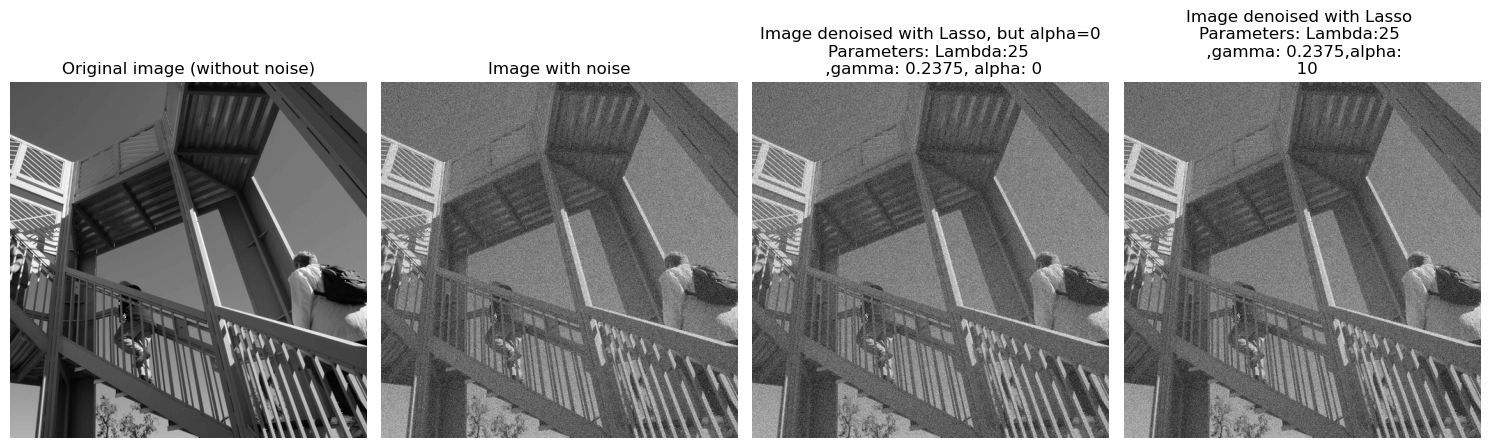

In [167]:
# Create a figure with a row of 3 subplots
fig, axs = plt.subplots(1, 4, figsize=(15, 5))


axs[0].imshow(xsharp, cmap='gray')
axs[0].set_title('Original image (without noise)')

# Display each image in a subplot
axs[1].imshow(noised_image, cmap='gray')
axs[1].set_title('Image with noise')

axs[2].imshow(revert_denoised_image_nolasso, cmap='gray')
axs[2].set_title(f"Image denoised with Lasso, but alpha=0\nParameters: Lambda:{Lambda} \n ,gamma: {gamma}, alpha: {0}")

axs[3].imshow(revert_denoised_image_lasso, cmap='gray')
axs[3].set_title(f"Image denoised with Lasso \nParameters: Lambda:{Lambda} \n ,gamma: {gamma},alpha:\n  {alpha}")

# Remove axes for a cleaner look

for ax in axs:
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

#### Trying to optimize hyperparameters

In [111]:
#from sklearn.model_selection import ParameterGrid
#from skimage.metrics import peak_signal_noise_ratio as psnr
#
#
#Lambda_values = np.linspace(10, 100, 10)  
#gamma_values = np.linspace(0.1, 1.9/8, 10)  
#alpha_values = np.linspace(0, 100, 10)  
#
#param_grid = {
#    'Lambda': Lambda_values,
#    'gamma': gamma_values,
#    'alpha': alpha_values,
#}
#
#param_combinations = list(ParameterGrid(param_grid))
#
#best_psnr = -np.inf
#best_params = None
#best_xdenoised = None
#
#psnr_values = []
#
#for params in param_combinations:
#    Lambda = params['Lambda']
#    gamma = params['gamma']
#    alpha = params['alpha']
#
#    xdenoised, Ep_array, Ed_array = chambolle_algorithm(noised_image, Lambda, gamma, alpha, nbiter, homemade=True)
#    
#    # Assuming `original_image` is the ground truth image without noise
#    #print(xdenoised,xsharp)
#    current_psnr = psnr(xsharp, xdenoised,data_range=255)
#    psnr_values.append((Lambda, gamma, alpha, current_psnr))
#    
#    if current_psnr > best_psnr:
#        best_psnr = current_psnr
#        best_params = params
#        best_xdenoised = xdenoised
#
#print(f"Best Parameters: {best_params}")
#print(f"Best PSNR: {best_psnr}")
#
## Visualize the best denoised image
#import matplotlib.pyplot as plt
#
#plt.figure(figsize=(9,9))
#plt.imshow(best_xdenoised, cmap='gray')
#plt.title(f"Best Denoised Image\nParameters: {best_params}")
#plt.show()
#
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#
## Unpack psnr values for plotting
#Lambda_vals, gamma_vals, alpha_vals, psnr_vals = zip(*psnr_values)
#
#sc = ax.scatter(Lambda_vals, gamma_vals, alpha_vals, c=psnr_vals, cmap='viridis')
#ax.set_xlabel('Lambda')
#ax.set_ylabel('gamma')
#ax.set_zlabel('alpha')
#plt.colorbar(sc, label='PSNR')
#plt.title('PSNR for different parameter combinations')
#plt.show()

In [ ]:
#low_noise_denoised,_,_  = chambolle_algorithm(low_noise_image,Lambda,gamma,alpha,nbiter)
#mid_noise_denoised,_,_  = chambolle_algorithm(mid_noise_image,Lambda,gamma,alpha,nbiter)
#higher_noise_denoised,_,_  = chambolle_algorithm(higher_noise_image,Lambda,gamma,alpha,nbiter)
#highest_noise_denoised,_,_  = chambolle_algorithm(highest_noise_image,Lambda,gamma,alpha,nbiter)

In [574]:
#def chambolle_algorithm(noised_image, Lambda, gamma, alpha, nbiter):
#    """
#    Perform denoising on a noised image using the Chambolle's algorithm.
#
#    Parameters
#    ----------
#    noised_image : Input image, corrupted by noise (2-D or 3-D np.ndarray)
#                   If 3-D, the last dimension should be the number of channels (e.g., 3 for RGB).
#    Lambda : Multiplicative coefficient of the TV term (float)
#    gamma : Proximal operators coefficient (float)
#    alpha : Constant that multiplies the L1 term, controlling regularization strength. (float)
#    nbiter : Number of iterations to run the algorithm (int)
#
#    Returns
#    -------
#    xdenoised : The denoised image obtained after `nbiter` iterations. (2-D or 3-D np.ndarray)
#    Ep_array : Array containing the primal energy values at each iteration. (np.ndarray)
#    Ed_array : Array containing the dual energy values at each iteration. (np.ndarray)
#
#    """
#    if noised_image.ndim == 2:
#        noised_image = noised_image[:, :, np.newaxis]
#
#    num_channels = noised_image.shape[2]
#    denoised_channels = []
#    Ep_list = []
#    Ed_list = []
#
#    for channel in range(num_channels):
#        noised_channel = noised_image[:, :, channel]
#
#        # Initializing u & x
#        (N1, N2) = noised_channel.shape
#        u = np.zeros([N1, N2, 2])
#        x = np.zeros([N1, N2])
#
#        # Initializing energy arrays
#        Ep_array = np.zeros(nbiter)  # array for the primal energy E_p
#        Ed_array = np.zeros(nbiter)  # array for the dual energy E_d
#
#        # Squared norm of the noised image
#        sqnormy = np.linalg.norm(noised_channel) ** 2 / 2
#
#        # Iterations of the Chambolle Algorithm
#        for iter in range(nbiter):
#            # Computing x and u, appending resulting energies in their respective arrays
#            x = -Dadj(u) + noised_channel
#            u = complete_proximal_operator(u, x, gamma, Lambda, alpha)
#            Ep_array[iter] = np.linalg.norm(x - noised_channel) ** 2 / 2 + Lambda * np.sum(
#                np.sqrt(np.sum(D(x) ** 2, 2)))
#            Ed_array[iter] = np.linalg.norm(noised_channel - Dadj(u)) ** 2 / 2 - sqnormy
#
#            # Debug: Print energy values to understand the issue
#            print(f"Iteration {iter}: Ep = {Ep_array[iter]}, Ed = {Ed_array[iter]}")
#
#        # Last x obtained is the denoised version of noised_channel, we return it
#        denoised_channel = x
#        denoised_channels.append(denoised_channel)
#        Ep_list.append(Ep_array)
#        Ed_list.append(Ed_array)
#
#    # Stack denoised channels to form the final denoised image
#    xdenoised = np.stack(denoised_channels, axis=-1)
#    Ep_array = np.mean(Ep_list, axis=0)
#    Ed_array = np.mean(Ed_list, axis=0)
#
#    return xdenoised, Ep_array, Ed_array

### Comparing performances with the original Chambolle algorithm

In the original implementation of the Chambolle algorithm the unisotropic term doesn't appear and the implementation is therefore much simpler :